## Imports

In [4]:
#------------------ General Purpose Imports ---------------------#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
from timeit import default_timer as timer
import pickle

#------------------ Machine Learning Imports ---------------------#
import torch
import scipy
import torch.utils.data
from sklearn.model_selection import train_test_split

#------------------ Dataset imports ---------------------#
import dysts
from dysts import flows


In [5]:
#------------------ system imports ---------------------#
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../..')))
import gc
import tracemalloc

#------------------ reservoirgrid imports ---------------------#
from reservoirgrid.models import Reservoir
from reservoirgrid.helpers import utils
from reservoirgrid.helpers import viz
from reservoirgrid.helpers import chaos_utils
from reservoirgrid.helpers import reservoir_tests
#--------------------------------------------------------------#

## Loading System

In [ ]:
result_path = "results/Chaotic/Lorenz/"
file_name = "10.0.pkl"
with open(result_path , 'rb') as f:
    data = pickle.load(f)

## Analysis of single Parameter across results

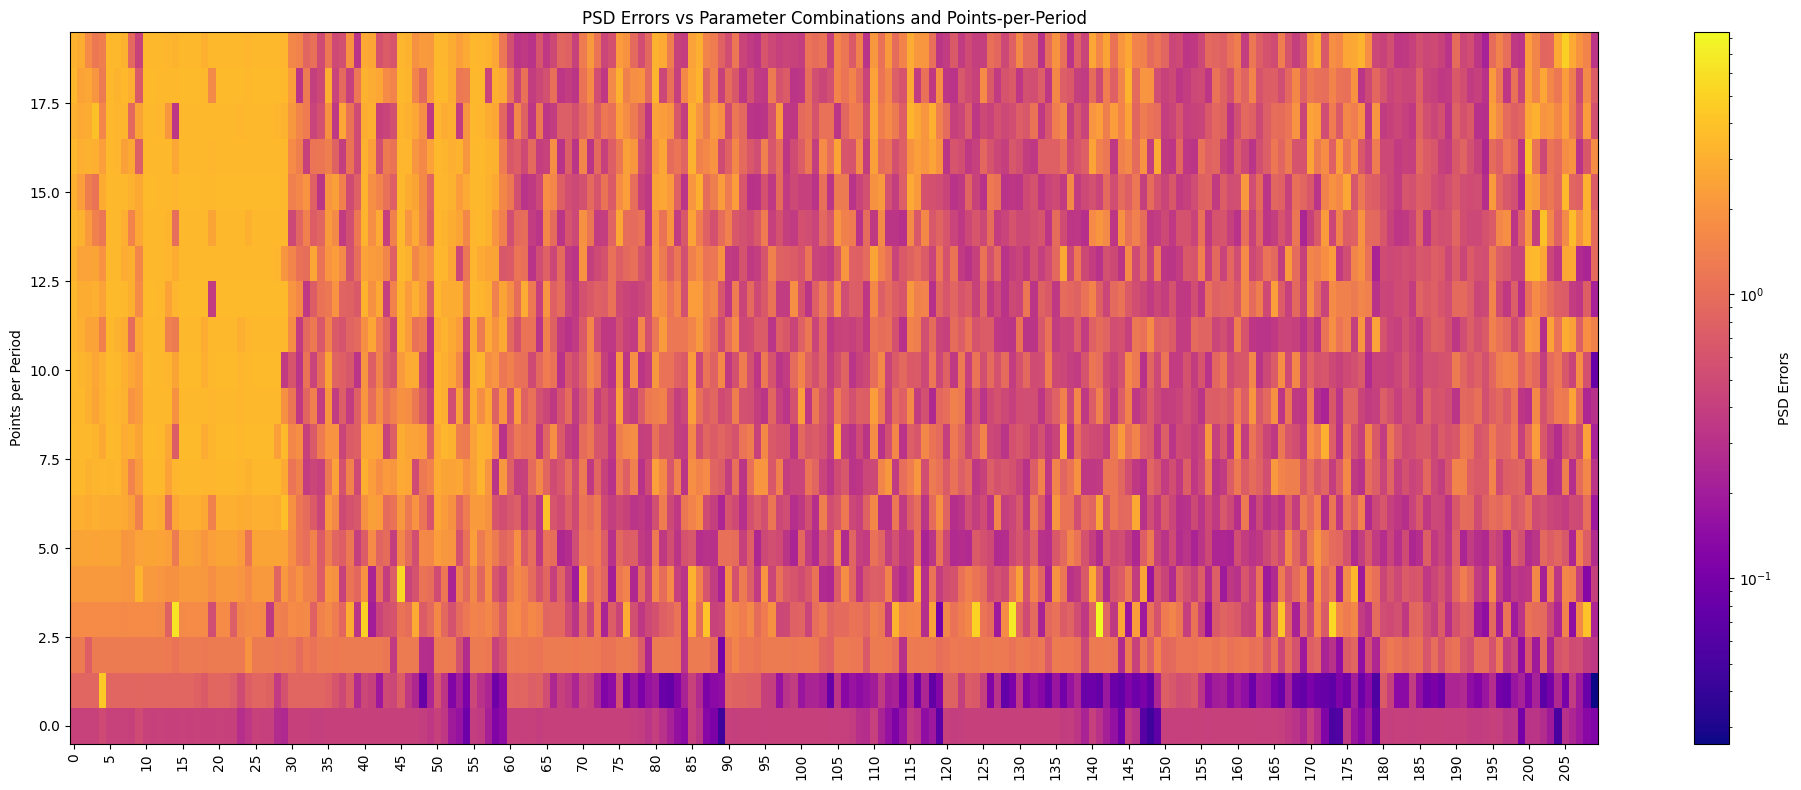

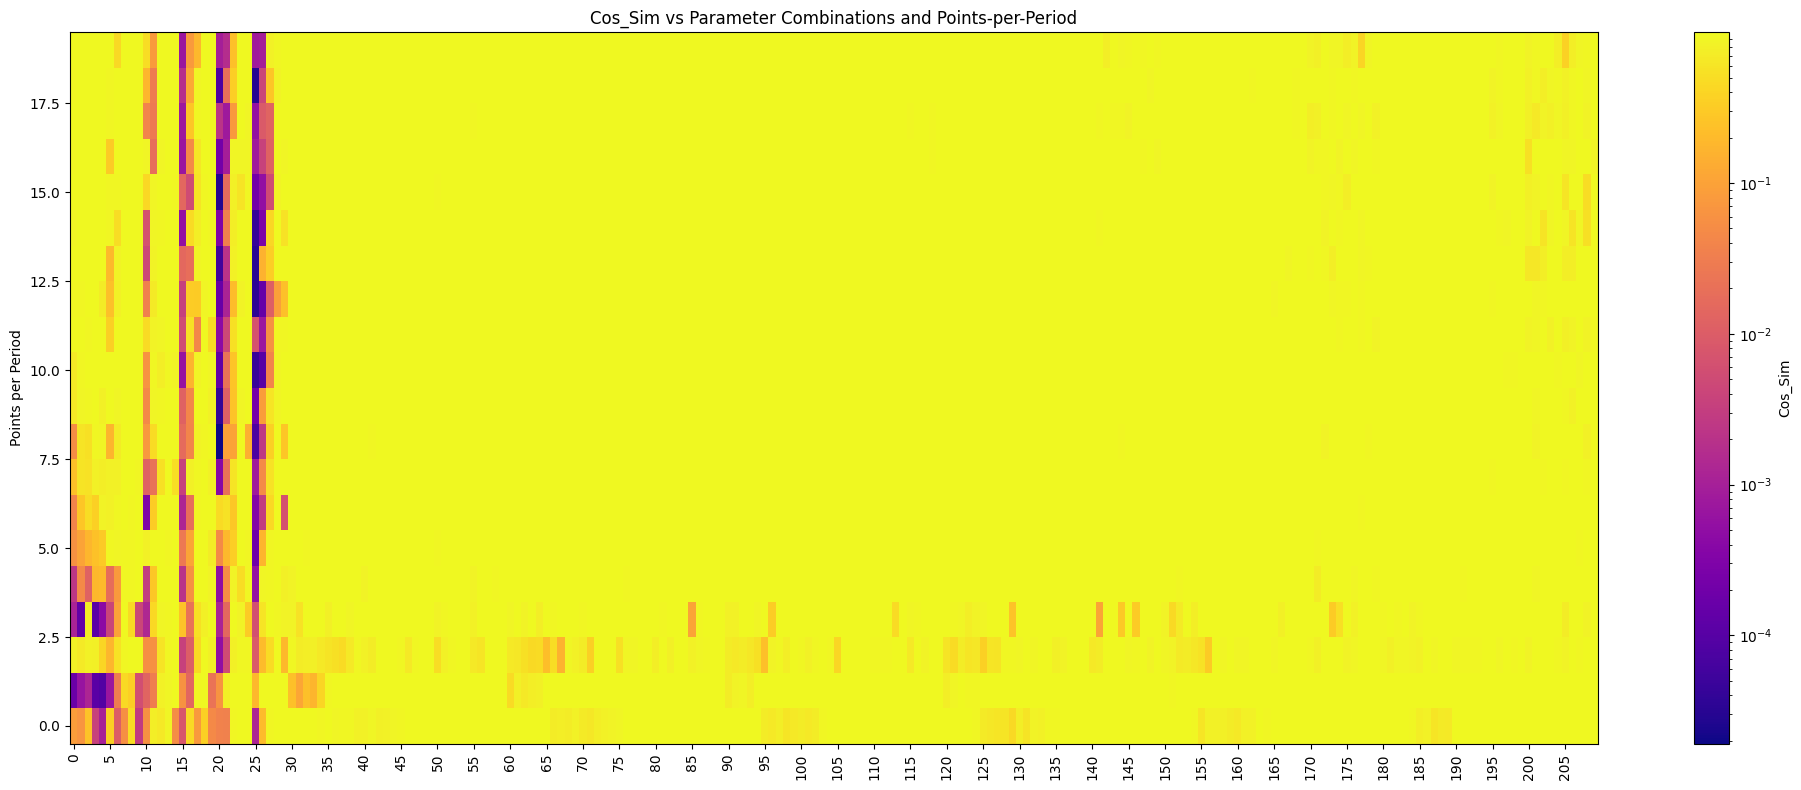

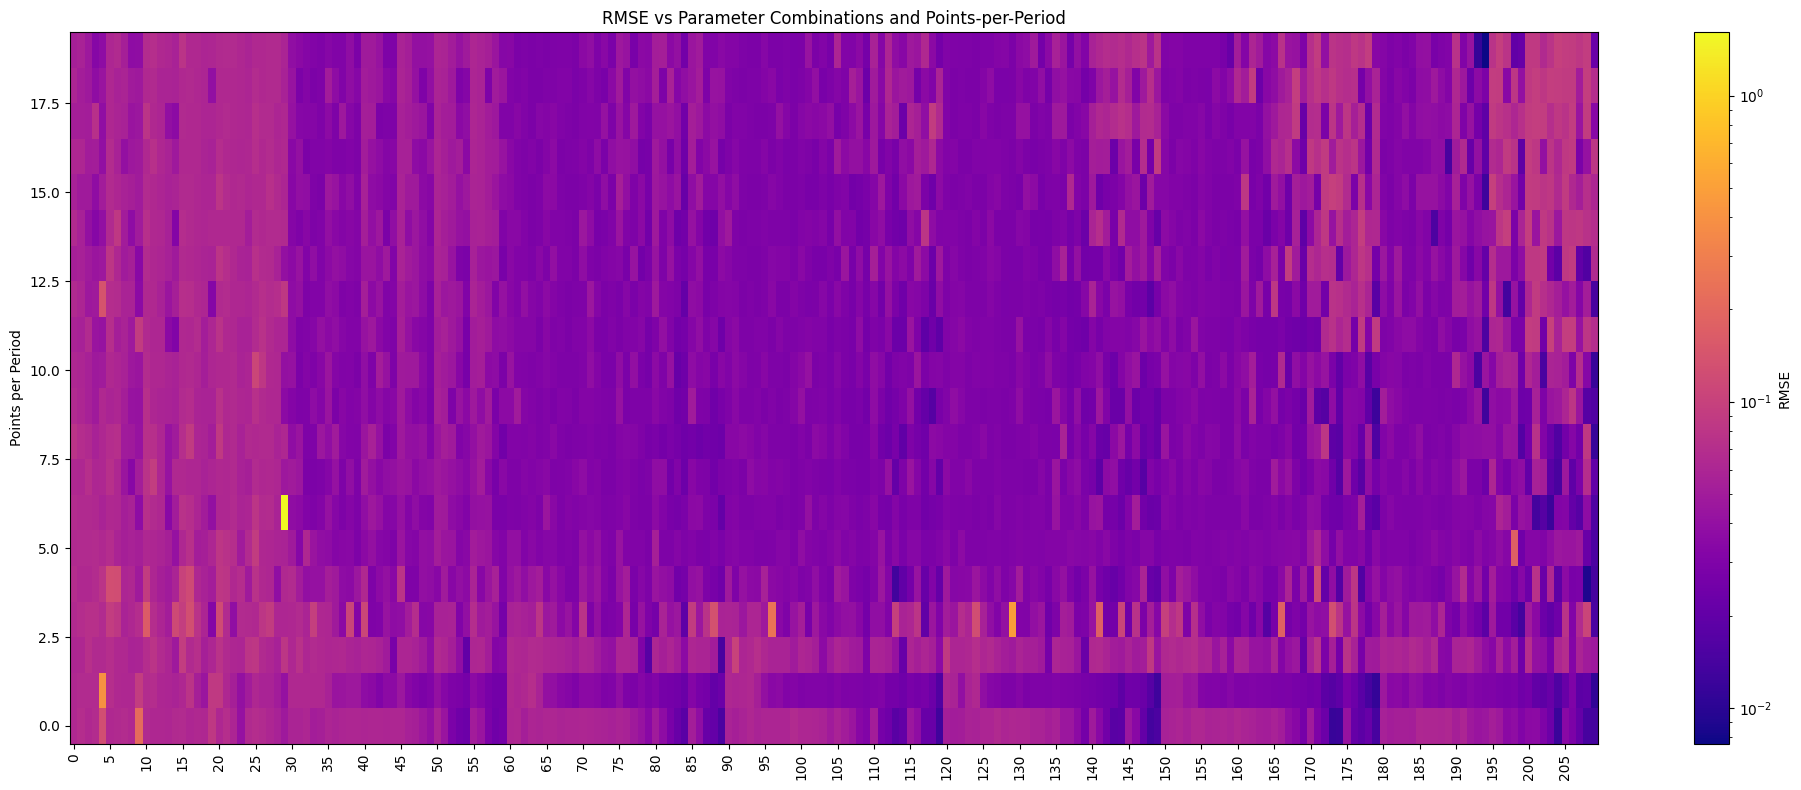

In [6]:
result_path = "results/Quasiperiodic/Torus/"
all_data = []
for file_name in os.listdir(result_path):
    if not file_name.endswith('.pkl'):
        continue
    
    ppp = float(file_name[:-4])  # Extract points-per-period
    file_path = os.path.join(result_path, file_name)
    
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    for entry in data:
        params = entry['parameters']
        psd, cos_sim = chaos_utils.psd_errors(entry['true_value'], entry['predictions'], return_cos_sim=True)

        all_data.append({
            'ppp': ppp,
            'params': params,  # Store the full parameter dictionary
            'PSD Errors' : psd,
            'Cos_Sim': cos_sim,
            'RMSE': entry['metrics']['RMSE']
        })

    del data
    gc.collect()



# Convert to DataFrame for easier manipulation
import pandas as pd
df = pd.DataFrame(all_data)
del all_data
gc.collect()

# Create unique identifiers for each parameter combination
df['param_combo'] = df['params'].apply(lambda x: tuple(sorted(x.items())))

# Get sorted unique values
unique_ppp = np.sort(df['ppp'].unique())
unique_param_combos = sorted(df['param_combo'].unique())

#Define metrics to plot
metrics = ['PSD Errors', 'Cos_Sim', 'RMSE']  # Add all your metrics here

for metric in metrics:
    # Create heatmap matrix for current metric:
    heatmap = np.full((len(unique_ppp), len(unique_param_combos)), np.nan)
    
    for i, ppp in enumerate(unique_ppp):
        for j, combo in enumerate(unique_param_combos):
            match = df[(df['ppp'] == ppp) & (df['param_combo'] == combo)]
            if not match.empty:
                heatmap[i, j] = match[metric].values[0]
    
    # Plotting
    plt.figure(figsize=(20, 8))
    plt.imshow(heatmap, 
               cmap='plasma',
               aspect='auto',
               origin='lower',
               interpolation='nearest',
               norm = LogNorm())
    
    # Customize plot for metric
    xticks = range(0, len(unique_param_combos), 5)
    xlabels=[f"{i}" for i in xticks]
    plt.xticks(ticks=xticks, labels=xlabels, rotation=90)
    plt.ylabel('Points per Period')
    plt.colorbar(label=metric)
    plt.title(f'{metric} vs Parameter Combinations and Points-per-Period')
    plt.tight_layout()
    
    # Save with metric-specific filename
    plt.savefig(f"{result_path}{metric}.png", dpi=600)
    plt.show()

## Best RMSE

In [4]:
Best_param_num = np.argmin([data[i]['metrics'] ['RMSE'] for i in range(len(data))]).item()
print(f"Parameters {Best_param_num} {data[Best_param_num]['parameters']}, RMSE = {data[Best_param_num]['metrics']['RMSE']}")
viz.compare_plot(datasets=[data[Best_param_num]['true_value'], data[Best_param_num]['predictions']], titles=["true","preds"], figsize=(1080,600))

Parameters 190 {'SpectralRadius': 1.1, 'LeakyRate': 0.7, 'InputScaling': 0.2}, RMSE = 0.2383746287312738


## Lyapunov of best RMSE

In [5]:
predictions  = data[Best_param_num]['predictions']
truth = data[Best_param_num]['true_value']
threshold = 0.1

print(f"Lyapunov of prediction {chaos_utils.lyapunov_time(predictions,threshold=0.1)}")
print(f"Error grows to {threshold} from the truth after {chaos_utils.comparative_lyapunov_time(truth, predictions, threshold=0.1)} time steps")

Lyapunov of prediction 1
Error grows to 0.1 from the truth after 0 time steps


## Other Parameters

In [6]:
select = 104
print(f"Parameters {select} {data[select]['parameters']}, RMSE = {data[select]['metrics']['RMSE']}")
viz.compare_plot(datasets=[data[select]['true_value'], data[select]['predictions']], titles=["true","preds"])

Parameters 104 {'SpectralRadius': 0.9, 'LeakyRate': 0.5, 'InputScaling': 1.0}, RMSE = 2.6961595124299853


## Lyapunov Analysis

In [7]:
predictions  = data[select]['predictions']
truth = data[select]['true_value']
threshold = 0.1
#print(chaos_utils.lyapunov_time_from_fit(true = truth, pred=predictions, fit_range=1))
print(f"Lyapunov of prediction {chaos_utils.lyapunov_time(predictions,threshold=2.1)}")
print(f"Lyapunov of ground truth {chaos_utils.lyapunov_time(truth,threshold=2.1)}")
print(f"Error grows to {threshold} from the truth after {chaos_utils.comparative_lyapunov_time(truth, predictions, threshold=0.1)} time steps")

Lyapunov of prediction 3
Lyapunov of ground truth 233
Error grows to 0.1 from the truth after 2 time steps


In [8]:
viz.plot_components(trajectory=predictions, figsize=(1080,600), line_width=1.5, title="Preds", labels=["X","Y","Z"])
viz.plot_components(trajectory=truth, figsize=(1080,600), line_width=1.5, title="Truth", labels=["X","Y","Z"])

## Recurrnece Plot

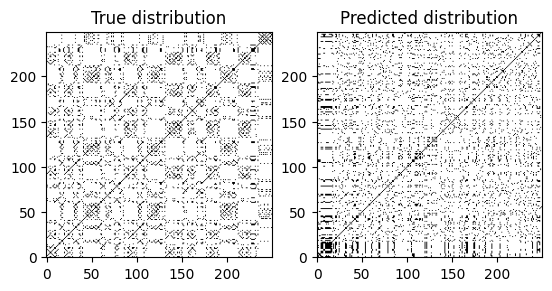

In [9]:
from pyts.image import RecurrencePlot

trajectory_true = truth[:500, 0]  
trajectory_pred = predictions[:500, 0]  

# RP object
rp = RecurrencePlot(threshold='point', percentage=10)

rp_true = rp.fit_transform(trajectory_true.reshape(1, -1))
rp_pred = rp.fit_transform(trajectory_pred.reshape(1, -1))

plt.subplot(1, 2, 1)
plt.imshow(rp_true[0], cmap='binary', origin='lower')
plt.title("True distribution")

plt.subplot(1, 2, 2)
plt.imshow(rp_pred[0], cmap='binary', origin='lower')
plt.title("Predicted distribution")
plt.show()

## KL Divergence

In [10]:
chaos_utils.KLdivergence(true = truth, predicted=predictions, bins=100)

24.492882688775307

## Correlation dimension

/tmp/ipykernel_33551/4026078948.py:27: RuntimeWarning:

divide by zero encountered in log



Estimated Correlation Dimension D2 of true: 1.8899454193329175 and of pred:  nan


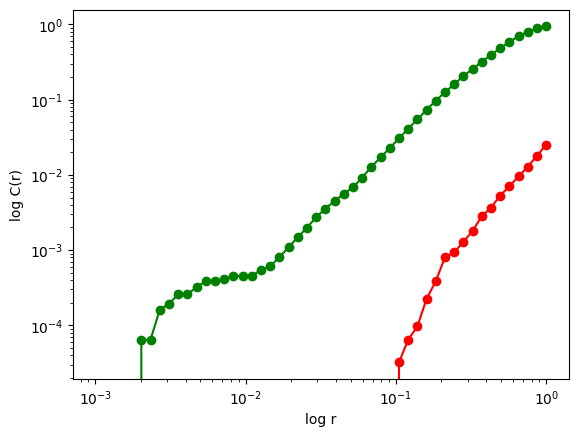

In [11]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

def correlation_dimension(data, r_vals):
    N = len(data)
    dists = squareform(pdist(data))  # pairwise distances
    C = []
    for r in r_vals:
        count = np.sum(dists < r) - N  # remove diagonal
        C_r = count / (N * (N - 1))
        C.append(C_r)
    return np.array(C)


r_vals = np.logspace(-3, 0, 50)
pred_c = correlation_dimension(predictions, r_vals)
true_c = correlation_dimension(truth, r_vals)

plt.loglog(r_vals, pred_c, 'o-', color = 'red' )
plt.loglog(r_vals, true_c, '-o', color = 'green' )
plt.xlabel("log r")
plt.ylabel("log C(r)")

# Fit slope in scaling region
fit_range = (r_vals > 0.01) & (r_vals < 0.1)
slope1 = np.polyfit(np.log(r_vals[fit_range]), np.log(pred_c[fit_range]), 1)[0]
slope2 = np.polyfit(np.log(r_vals[fit_range]), np.log(true_c[fit_range]), 1)[0]
print("Estimated Correlation Dimension D2 of true:", slope2, "and of pred: " , slope1)


## Power Spectral Density

/home/ragedpi/Reservoir_Pytorch/.venv/lib64/python3.13/site-packages/scipy/signal/_spectral_py.py:790: UserWarning:

nperseg = 1024 is greater than input length  = 250, using nperseg = 250



Error in PSD (Lower is better): 59.35706598364744
Cosine Similarity(Ideal Value 1): 0.5654186478756775
Wasserstein Distance(Ideal Value 0): 2.954675010663244


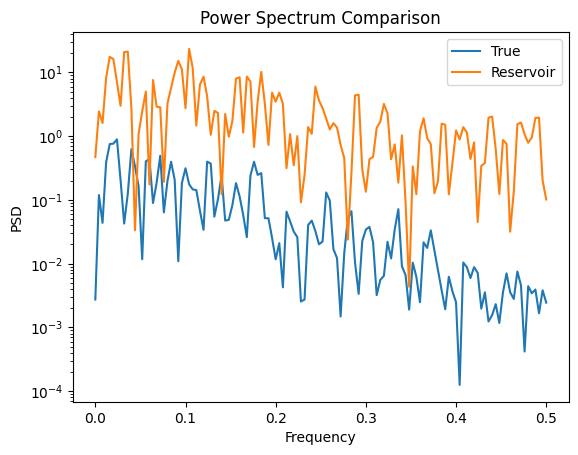

In [12]:
from scipy.signal import welch
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wasserstein_distance


f, P_true = welch(truth[:, 0], fs=1.0, nperseg=1024)
_, P_pred = welch(predictions[:, 0], fs=1.0, nperseg=1024)

psd_error = np.linalg.norm(P_true - P_pred)
cos_sim = cosine_similarity(P_true.reshape(1, -1), P_pred.reshape(1, -1))[0][0]
emd = wasserstein_distance(P_true, P_pred)

plt.semilogy(f, P_true, label="True")
plt.semilogy(f, P_pred, label="Reservoir")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.title("Power Spectrum Comparison")
print(f"Error in PSD (Lower is better): {psd_error.item()}")
print(f"Cosine Similarity(Ideal Value 1): {cos_sim}")
print(f"Wasserstein Distance(Ideal Value 0): {emd}") # This does not seem very good. everything is close to 0

## Topological Data Analysis

In [13]:
from ripser import ripser
from persim import plot_diagrams, wasserstein

def filter_diagram(diag, threshold=1e-2):
    return np.array([pt for pt in diag if abs(pt[1] - pt[0]) > threshold])

diagrams_true = ripser(truth)['dgms']
diagrams_pred = ripser(predictions)['dgms']

#Earth-Movers Distance
dgm1 = filter_diagram(diagrams_true[1])
dgm2 = filter_diagram(diagrams_pred[1])
d = wasserstein(dgm1, dgm2)

Topological distance (H1):10.090684492228995


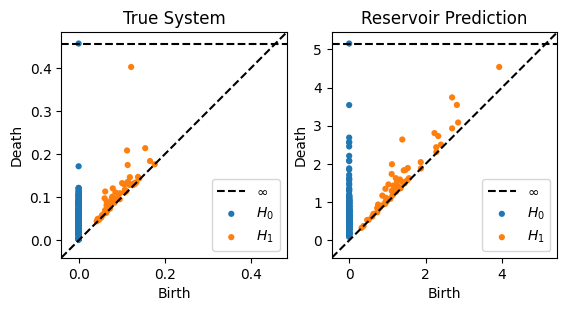

In [14]:
plt.subplot(1, 2, 1)
plot_diagrams(diagrams_true, title='True System')

plt.subplot(1, 2, 2)
plot_diagrams(diagrams_pred, title='Reservoir Prediction')

print(f"Topological distance (H1):{d}")